# Numerical Methods for Jump Diffusions

Click here for an interactive version of this notebook:-
[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/pjohno/MSc-Math-Finance-2018/master?filepath=notebooks%2FMSc%20Project%208%20-%20Jump%20Diffusion.ipynb)


Here we solve the problem for option pricing with jump diffusions. Assume that the risk adjusted stock price follows the SDE
$$
\frac{dS}{S} = (r-d-\lambda \kappa) dt + \sigma dW + (\eta -1 ) dq
$$
where 

- $r$ is the risk free interest rate
- $d$ is the dividend yield
- $(r-d-\lambda \kappa)$ is the risk adjusted drift rate
- $\sigma$ is the volatility
- $dq$ is a Poisson process and $(\eta -1)$ is the relative size of the jump in $S$
- $\lambda$ is the intensity rate of jumps, so that $\lambda dt$ is the probability of jump happening 
- $g(\eta)$ is the probability density function for the size of the jump
- $\kappa = \int_0^\infty (\eta-1)g(\eta) d\eta$ is the expected relative size of the jump, so that $$\text{E}\left[(\eta-1)dq\right]-\lambda\kappa dt =0$$

Then contingent claims $V$ written on the asset $S$ can be priced from the following equation
$$
\frac{\partial V}{\partial t} + \frac12 \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} +
(r-d-\lambda\kappa)S \frac{\partial V}{\partial S} - (r+\lambda)V + \lambda \int_0^\infty g(\eta) V(\eta S,t) d\eta = 0
$$

Assume that the state space is discretised with a standard fixed spaced grid, so that
$$
S_j = j\Delta S
$$
and
$$
t^i = i\Delta t .
$$

We solve this problem using a simple implicit-explicit scheme to take care of the jumps. We assume that the jump integration term can be calculated using a trapezium rule, so that
$$
J(S_j,t^i) = \int_0^\infty g(\eta) V(\eta S_j,t^i) d\eta \approx \sum_k g\left(S_k/S_j+\frac12 \Delta S/S_j\right) \frac12 (v_k^i+v_{k+1}^i)\Delta S 
$$
where
$$
V(\eta_k S_j , t^i ) = v_k^i \quad \text{ and } \quad \eta_k = \frac{S_k}{S_j} .
$$

We write down an implicit scheme for the diffusion part and an explicit scheme for the jump, so that we have to solve

$$
a_j v^i_{j-1} +b_j v^i_j + c_j v^i_{j+1}= d_j  
$$

where the coefficients are
$$
a_j = \frac12\sigma^2j^2 -  \frac12(r-d-\lambda\kappa)j
$$ 
$$
b_j = -\sigma^2j^2-\frac{1}{dt};
$$ 
$$
c_j = \frac12\sigma^2j^2 + \frac12(r-d-\lambda\kappa)j
$$ 
and 
$$
d_j = -\frac{v_j^{i+1}}{dt} - \lambda J(S_j,t^{i+1})
$$ 

## Example: d'Halluin et al (2005)

In the paper they choose a log-normal jump distribution of the form
$$
g(\eta;\mu,\gamma) = \frac{1}{\left(\sqrt{2\pi}\right)\gamma\eta}\exp\left(-\frac{\ln(\eta)-\mu}{2\gamma^2}\right)
$$
and set
$$
S_0=100, \quad X=100, \quad  T=0.25, \quad r=0.05, \quad d=0, \quad \sigma=0.15
$$
and
$$
\lambda=0.1, \quad \gamma=0.45\quad \mu = -0.9 ~ .
$$

Include standard libraries

In [1]:
#include "msc_project_8.hpp"

We can use a Thomas algorithm to solve the matrix problem $$A\mathbf{x} = \mathbf{b}$$where the matrix $A$ is of tridiagonal type with the diagonals referenced by the vectors $\mathbf{a}$, $\mathbf{b}$, $\mathbf{c}$ and the right hand side is $\mathbf{d}$. See [here](https://github.com/pjohno/MATH60082/blob/master/src/math60082_tridag.cpp) for an implementation.

Here we write a function to calculate the jump distribution. We input the value of $S_j$ along with the entire vectors of $S$ and $V$.

In [2]:
// function to calculate jump integral term
double trapeziumRule(double Sj,const std::vector<double> &S,
                     const std::vector<double> &v,double J_gamma,double J_mu)
{
    double sum=0.;
    for(int k=0;k<S.size()-1;k++)
    {
        double dS = (S[k+1]-S[k]);
        // value of S at mid point
        double Smid = 0.5*(S[k+1]+S[k]);
        double mu = log(Smid/Sj)-J_mu;
        double sig = 2*J_gamma*J_gamma;
        sum += dS*(v[k+1]+v[k])*exp((-mu*mu)/sig)/(sqrt(sig*M_PI)*Smid);
    }
    return 0.5*sum;
}

Now declare all storage for variables required

In [3]:
// declare and initialise Black Scholes parameters
double S0,X,T,r,sigma;
// declare jump stuff
double J_lambda,J_gamma;
double J_mu;
    
// declare and initialise grid paramaters 
int iMax,jMax;
double S_max;
double dS;
double dt;
std::vector<double> S,V;

and then assign the initial values

In [4]:
// declare and initialise Black Scholes parameters
S0=100;X=100.;T=0.25;r=0.05;sigma=0.15;
// declare jump stuff
J_lambda=0.1;J_gamma=0.45;J_mu = -0.9;
    
// initialise grid paramaters 
iMax=100,jMax=400;
// initialise local variables (ds,dt)
S_max=5*X;
dS=S_max/jMax;
dt=T/iMax;
// create storage for the stock price and option price (old and new)
S.resize(jMax+1);V.resize(jMax+1);
// setup and initialise the stock price 
for(int j=0;j<=jMax;j++)
{
    S[j] = j*dS;
}
// setup and initialise the final conditions on the option price 
for(int j=0;j<=jMax;j++)
{
    V[j] = std::max(X-S[j],0.);
    //cout << iMax << " " << j << " " << S[j] << " " << V[j] << endl;
}


Then we can start the timestepping algorithm. Following standard form we set up the matrix equations and then solve with the tridag function.

In [5]:
// start looping through time levels
for(int i=iMax-1;i>=0;i--)
{
    // declare vectors for matrix equations
    std::vector<double> a(jMax+1),b(jMax+1),c(jMax+1),d(jMax+1);
    // set up matrix equations a[j]=
    a[0] = 0.;b[0] = 1.;c[0] = 0.;
    d[0] = X*exp(-r*(iMax-i)*dt);
    for(int j=1;j<jMax;j++)
    {
        // calculate jump components
        double jumpDrift = J_lambda*(exp(J_mu+J_gamma*J_gamma/2.)-1.);
        double J_integral_Term = trapeziumRule(S[j],S,V,J_gamma,J_mu);
        
        // set up scheme
        a[j] = 0.5*(sigma*sigma*j*j-(r-jumpDrift)*j);
        b[j] =-sigma*sigma*j*j - (r+J_lambda) - 1./dt;
        c[j] = 0.5*(sigma*sigma*j*j+(r-jumpDrift)*j);
        
        // set up right hand side
        d[j] = -V[j]/dt - J_lambda * J_integral_Term;
    }
    a[jMax] = 0.;b[jMax] = 1.;c[jMax] = 0.;
    d[jMax] = 0.;
    // solve with Thomas 
    thomasSolve(a,b,c,d);
    // set old=new
    V=d;
}
// finish looping through time levels


Finally we can plot out the results

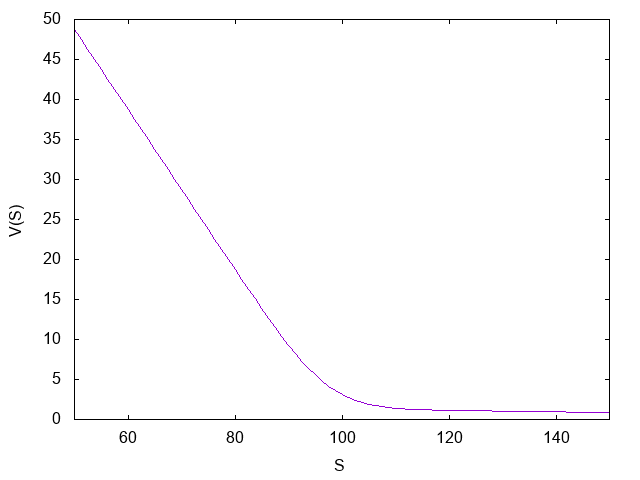

In [6]:
// plot the figure
{
    // add labels on the x/y axis
    std::stringstream ss("set xlabel \"S\"\n set ylabel \"V(S)\"\n"
                        "set xrange[50:150]");
    // put the plot in figure1
    figure = G.plotData(S,V,&ss);
}
// show figure
figure

See the full code solution on github [click here](https://github.com/pjohno/MSc-Math-Finance-2018/blob/master/main/project-8-jump-diffusion.cpp).